In [14]:
import geopandas 
import pandas as pd
pd.set_option('max_colwidth', 200)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns 
sns.set()
import descartes
%matplotlib inline
from random import sample
from math import sin, cos, sqrt, atan2, radians
import numpy as np

lakes = geopandas.read_file("Lakes_and_Rivers")
madison = geopandas.read_file("City_Limit")


#how to calculate the distance of two pairs of lats and lons
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

In [2]:
#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
weekday_bus = geopandas.read_file("Metro_Transit_Ridership_by_Route_Weekday")

weekday_bus.head()[:1]


,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry
0,16341,4100,4,43.038895,-89.394824,189.84,1898447.45,POINT (-89.39481797199609 43.03888706322148)


In [3]:
#metro data
metro_data = geopandas.read_file("MetroBusRoutes.gdb")
list_metro = []
for index, row in metro_data.iterrows():
    list_metro.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

metro_series = pd.Series(list_metro)
metro_coord = pd.DataFrame({"Coordinates": metro_series})
metro_coord = geopandas.GeoDataFrame(metro_coord, geometry='Coordinates')

#BRT data 
#https://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-stops
# using new data for brt from the madison data instead of the BRT.gdb
brt_data = geopandas.read_file("Bus_Rapid_Transit_Stops")
list_brt = []
for index, row in brt_data.iterrows():
    list_brt.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

brt_series = pd.Series(list_brt)
brt_coord = pd.DataFrame({"Coordinates": brt_series})
brt_coord = geopandas.GeoDataFrame(brt_coord, geometry='Coordinates')



In [4]:
#ref _ https://stackoverflow.com/questions/10202570/find-row-where-values-for-column-is-maximal-in-a-pandas-dataframe
# ref _ http://postgis.org/docs/ST_Distance.html
weekday_bus['brt_index'] = ''
weekday_bus['distance_to_brt'] = ''

for index, row in weekday_bus.iterrows():
    list_bus = []
    for index1, row1 in brt_data.iterrows(): 
        dist = row['geometry'].distance(row1['geometry'])
        list_bus.append(dist)
    list_bus_df = pd.DataFrame(list_bus)
    list_bus_df.columns =['distance_from_nearest_brt']

    index_of_brt = list_bus_df['distance_from_nearest_brt'].idxmin()
    distance_to_nearest_brt = list_bus_df['distance_from_nearest_brt'].min()

    weekday_bus.at[index, 'brt_index'] = index_of_brt
    weekday_bus.at[index, 'distance_to_brt'] = distance_to_nearest_brt

In [21]:
weekday_bus[:1]

,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry,brt_index,distance_to_brt
0,16341,4100,4,43.038895,-89.394824,189.84,1898447.45,POINT (-89.39481797199609 43.03888706322148),59,0.000143962


In [22]:
#weekday_bus.read_file('weekday_bus_with_brt_distance.gpkg', geometry = "geometry")

In [5]:
#metro data
metro_data = geopandas.read_file("MetroBusRoutes.gdb")
list_metro = []
for index, row in metro_data.iterrows():
    list_metro.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

metro_series = pd.Series(list_metro)
metro_coord = pd.DataFrame({"Coordinates": metro_series})
metro_coord = geopandas.GeoDataFrame(metro_coord, geometry='Coordinates')

#BRT data 
#https://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-stops
# using new data for brt from the madison data instead of the BRT.gdb
brt_data = geopandas.read_file("Bus_Rapid_Transit_Stops")
list_brt = []
for index, row in brt_data.iterrows():
    list_brt.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

brt_series = pd.Series(list_brt)
brt_coord = pd.DataFrame({"Coordinates": brt_series})
brt_coord = geopandas.GeoDataFrame(brt_coord, geometry='Coordinates')

#BRT data lines
#http://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-system-lines
brt_data_line = geopandas.read_file("Bus_Rapid_Transit_System_Lines")
brt_coord_line = geopandas.GeoDataFrame(brt_data_line, geometry='geometry')


In [6]:
#metro bus route data 2019
#http://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-bus-routes
transit_data = geopandas.read_file("Metro_Transit_Bus_Route_Trips")
transit_data_weekday = transit_data.loc[transit_data['service_na'].isin(['Standard Weekday','Weekday'])]
transit_data_weekday[:1]

,OBJECTID,PointsToLi,PointsTo_1,trips_rout,trips_ro_1,trips_ro_2,trips_ro_3,trips_ro_4,trips_ro_5,trips_ro_6,...,saturday,sunday,start_date,end_date,PK_MD_WE,ShapeSTLen,trips_ro20,trips_ro21,trips_ro22,geometry
0,27116,51841,51841,8460,1,87_WKD,894620,CAPITOL SQUARE,0,Capitol Square,...,0,0,20190825,20191130,010,15170.038428,None,None,None,"LINESTRING (-89.42863020308475 43.0720703101791, -89.42814820376813 43.07210531053178, -89.42712420362679 43.07218731165621, -89.4255892022808 43.07230831376807, -89.42513320243103 43.072343314370..."


In [7]:
#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
#weekday_bus_with_brt_distance = geopandas.read_file("weekday_bus_with_brt_distance.gpkg", driver = "GPKG")
#weekday_bus_with_brt_distance.distance_to_brt = weekday_bus_with_brt_distance.distance_to_brt.astype(float)
unique_value = weekday_bus['Route'].unique()
unique_value.sort()
unique_value

array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 44, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 67, 70, 71, 72, 73,
       75, 80, 81, 82, 84])

In [8]:
#mapping of the point
def mapping(route_number_table):
    for bus_number in route_number_table['Route'].unique():
        row_bus = weekday_bus[weekday_bus['Route'] == bus_number]  
        weekday_bus_series = pd.Series(row_bus["geometry"])
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='blue', ax=ax, markersize= 35)

    route_row = transit_data_weekday[transit_data_weekday['trips_ro_1'] == bus_number]
    list_weekday_bus = []
    for index, row in route_row.iterrows():
        list_weekday_bus.append(row["geometry"])
        weekday_bus_series = pd.Series(list_weekday_bus)
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='blue', ax=ax)

    for index, row in row_bus.iterrows():
        metro_point = row['geometry']
        brt_point = brt_data.iloc[int(row['brt_index'])]['geometry']
        line_A = LineString([[metro_point.x, metro_point.y], [brt_point.x, brt_point.y]])
        weekday_bus_series = pd.Series(line_A)
        weekday_bus_coord = pd.DataFrame({"Coordinates": weekday_bus_series})
        weekday_bus_coord = geopandas.GeoDataFrame(weekday_bus_coord, geometry='Coordinates')
        weekday_bus_coord.plot(color='red', ax=ax)


In [46]:
#dfforplot = pd.DataFrame({'count': [len(weekday_bus[weekday_bus['distance_to_brt'] <= 0.0013]),len(weekday_bus[weekday_bus['distance_to_brt'] > 0.0013])]}, index=['Walking Distance within 5 minutes','More than 5 minutes'])

#explode = (0.2, 0)
#plt.pie(dfforplot, labels= dfforplot['count'],explode=explode,counterclock=False, shadow=True)
#plt.title('BRT Bus stops that are within 5 minute walking distance from Metro bus stops')
#plt.legend(dfforplot.index,loc= 'lower left')
#plt.show()

# Visualizing distances of BRT stops to Existing routes

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count    29.000000
mean      0.002063
std       0.001536
min       0.000045
25%       0.001026
50%       0.001940
75%       0.002667
max       0.006036
Name: distance_to_brt, dtype: float64

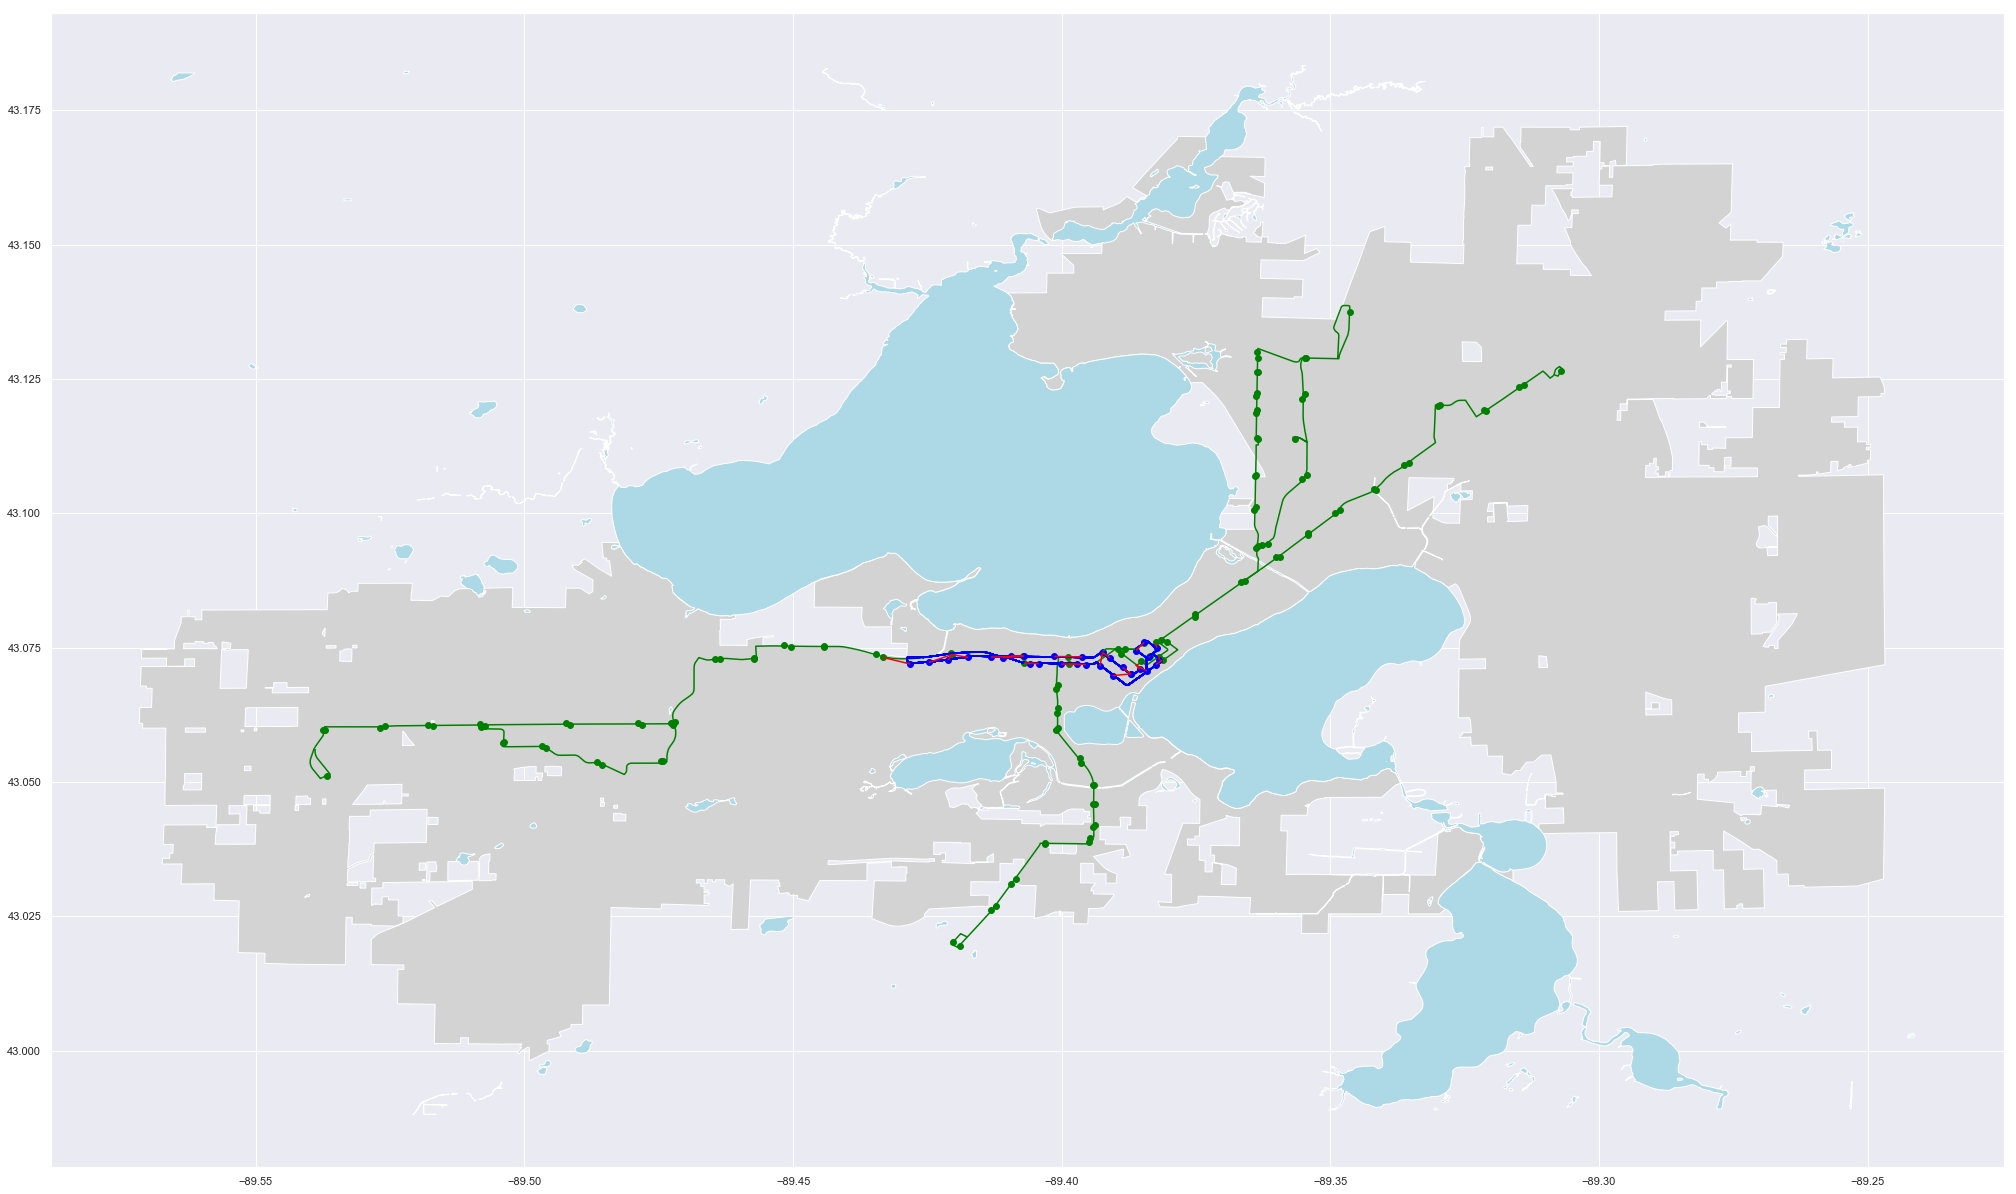

In [9]:
#bus 1 
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

route_number_table = weekday_bus[weekday_bus['Route'] == 1]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()

We see here that there are several BRT stops close in ditance to the BRT stops. Next week, we will try to do this same procedure and visualize more routes.  

count    120.000000
mean       0.002834
std        0.002025
min        0.000005
25%        0.001095
50%        0.002685
75%        0.004397
max        0.007641
Name: distance_to_brt, dtype: float64

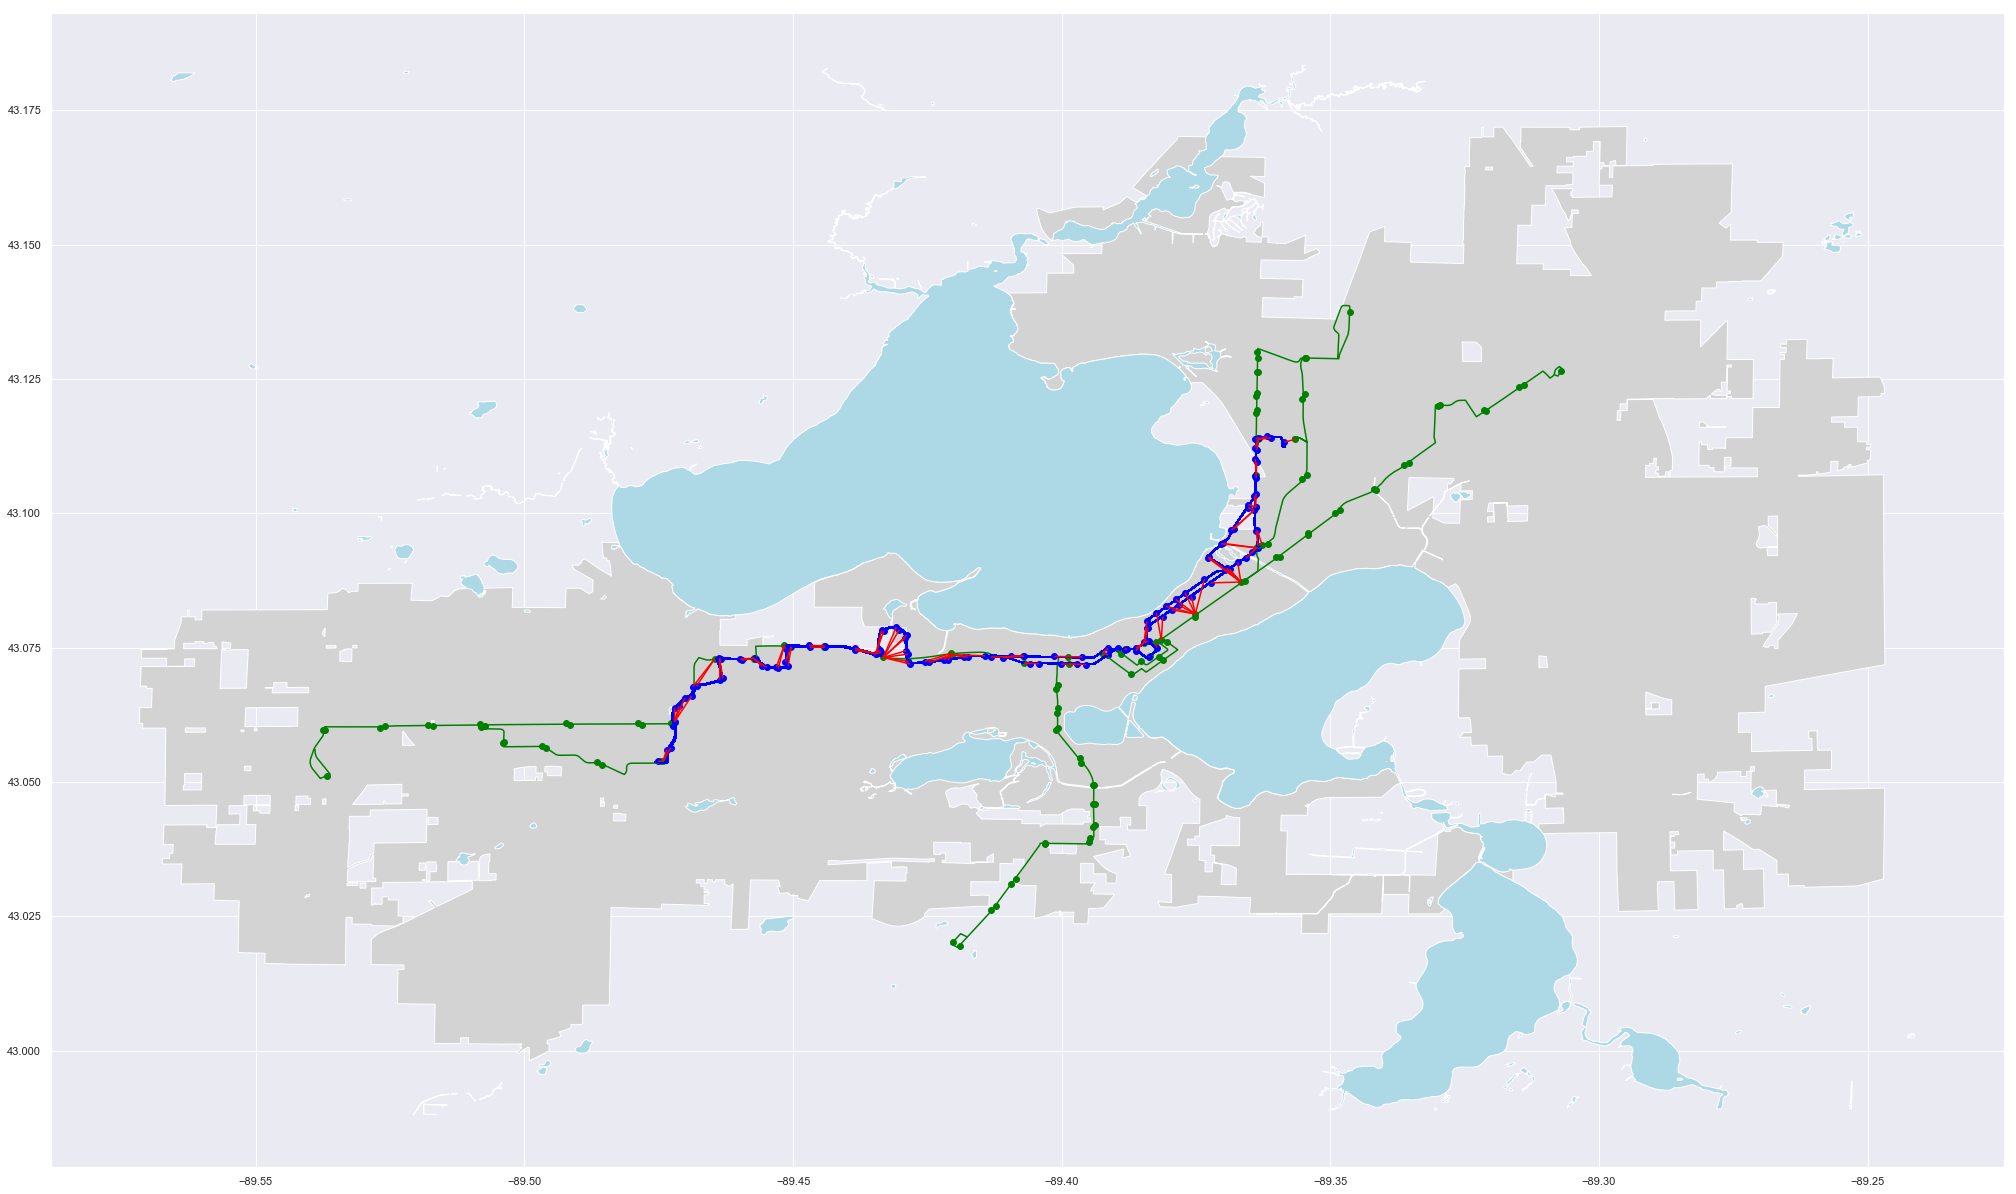

In [10]:
#bus 2
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)
route_number_table = weekday_bus[weekday_bus['Route'] == 2]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()

# Distance from existing stop to nearest BRT stop on exiting route

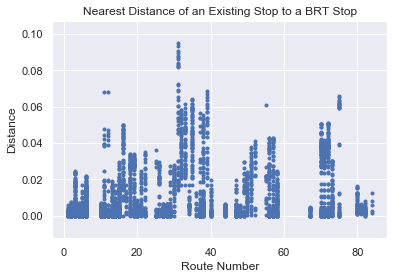

In [33]:
y = weekday_bus["distance_to_brt"]
x = weekday_bus["Route"]

plt.scatter(x, y, marker=".")
plt.title('Nearest Distance of an Existing Stop to a BRT Stop')
plt.xlabel('Route Number')
plt.ylabel('Distance')
plt.show()
#Still need to convert distance to miles or km 



In [23]:
y.describe()

count     3666.000000
unique    1808.000000
top          0.001377
freq        24.000000
Name: distance_to_brt, dtype: float64

We can see that there are a range of distances from existing stops to BRT stops along each route. This is an improved graph from last week as the numbers are updated and the x-axis now represents the actual routes of the existing bus network. 

In [44]:
weekday_bus[:1]

,OBJECTID,StopID,Route,Lat,Lon,DailyBoard,DotSize,geometry,brt_index,distance_to_brt
0,16341,4100,4,43.038895,-89.394824,189.84,1898447.45,POINT (-89.39481797199609 43.03888706322148),59,0.000143962


count    128.000000
mean       0.003176
std        0.001901
min        0.000017
25%        0.001758
50%        0.003175
75%        0.004531
max        0.007049
Name: distance_to_brt, dtype: float64

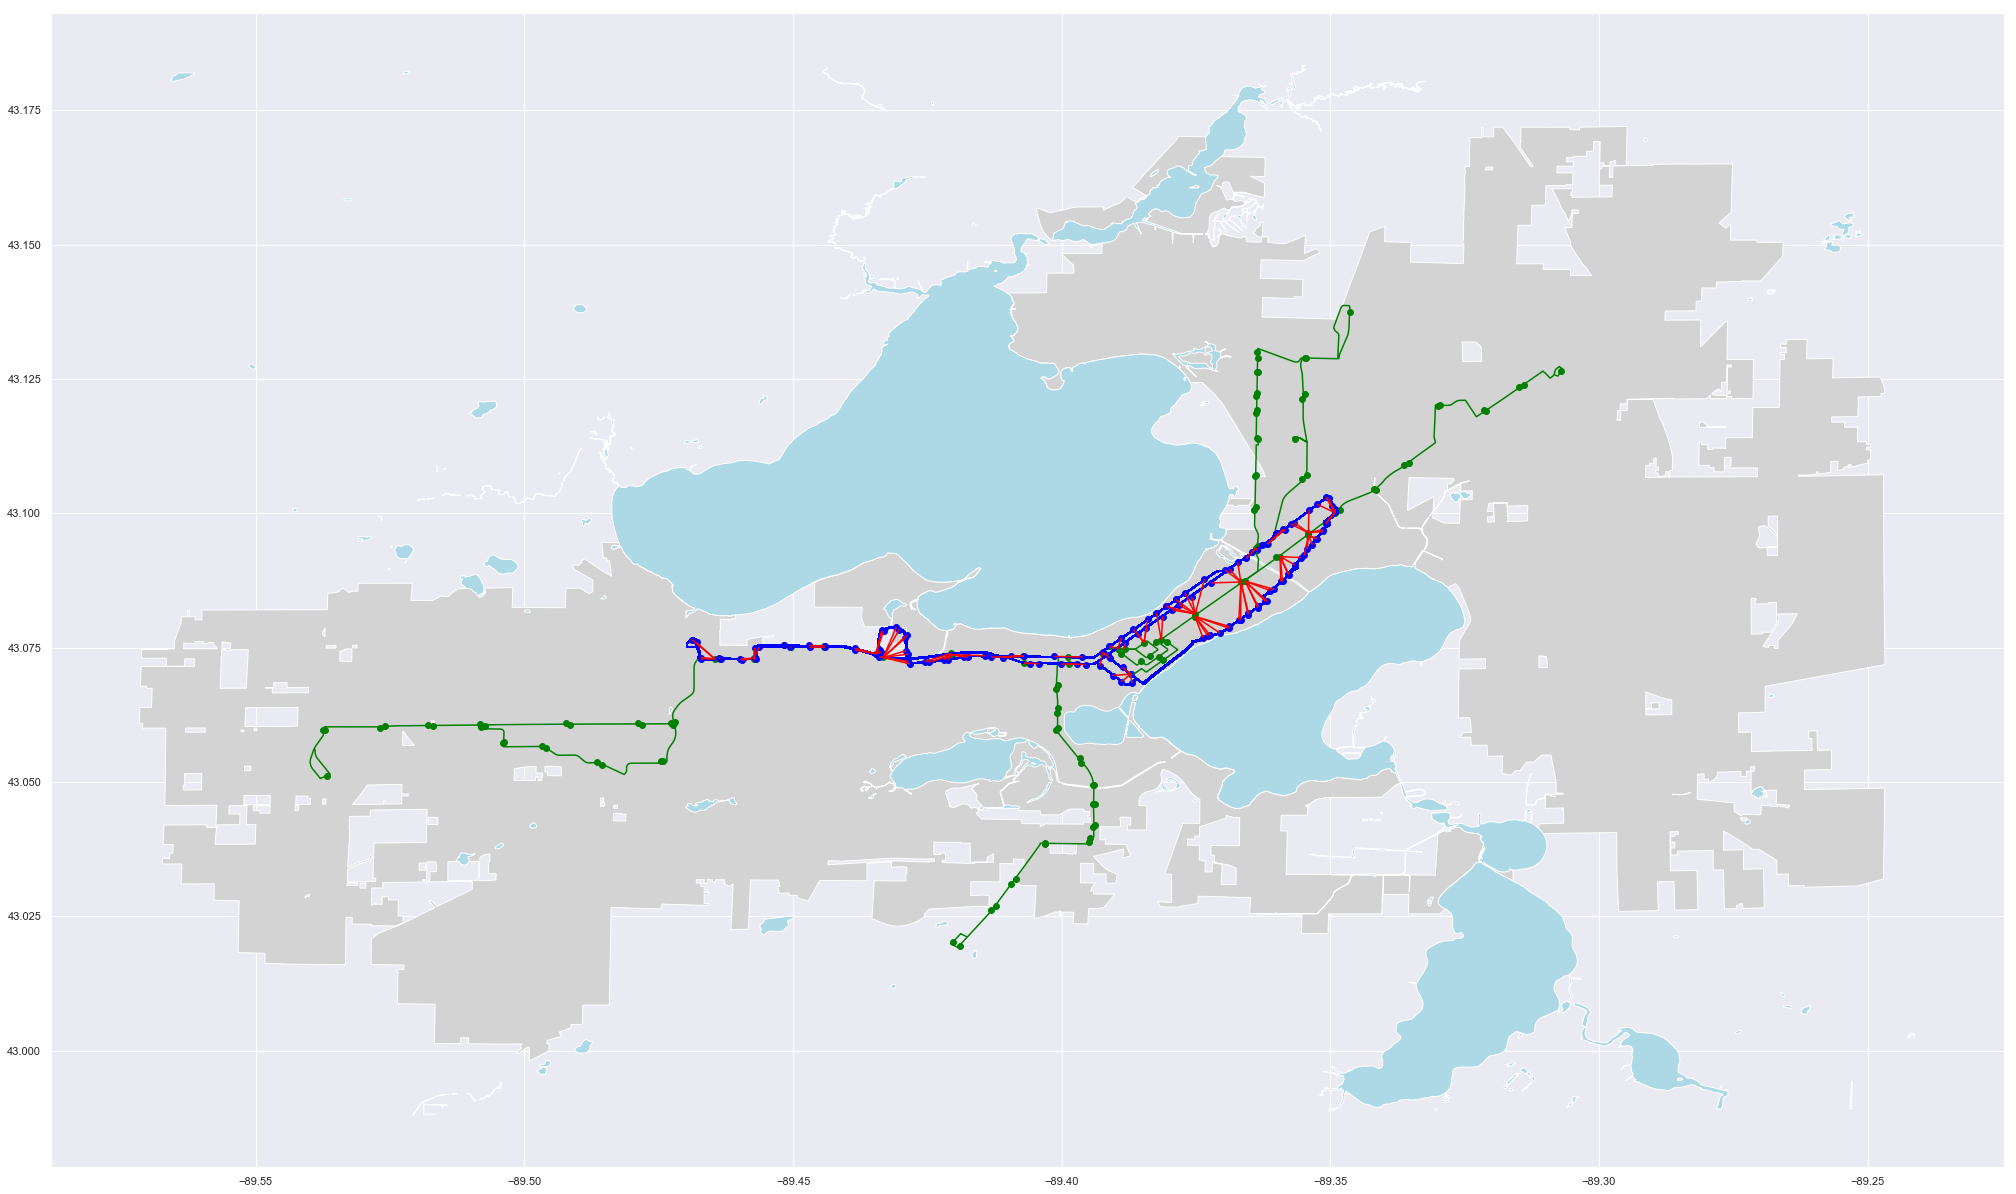

In [11]:
#bus 10
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

route_number_table = weekday_bus[weekday_bus['Route'] == 10]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()


count    86.000000
mean      0.002903
std       0.001928
min       0.000005
25%       0.001425
50%       0.002667
75%       0.004383
max       0.006699
Name: distance_to_brt, dtype: float64

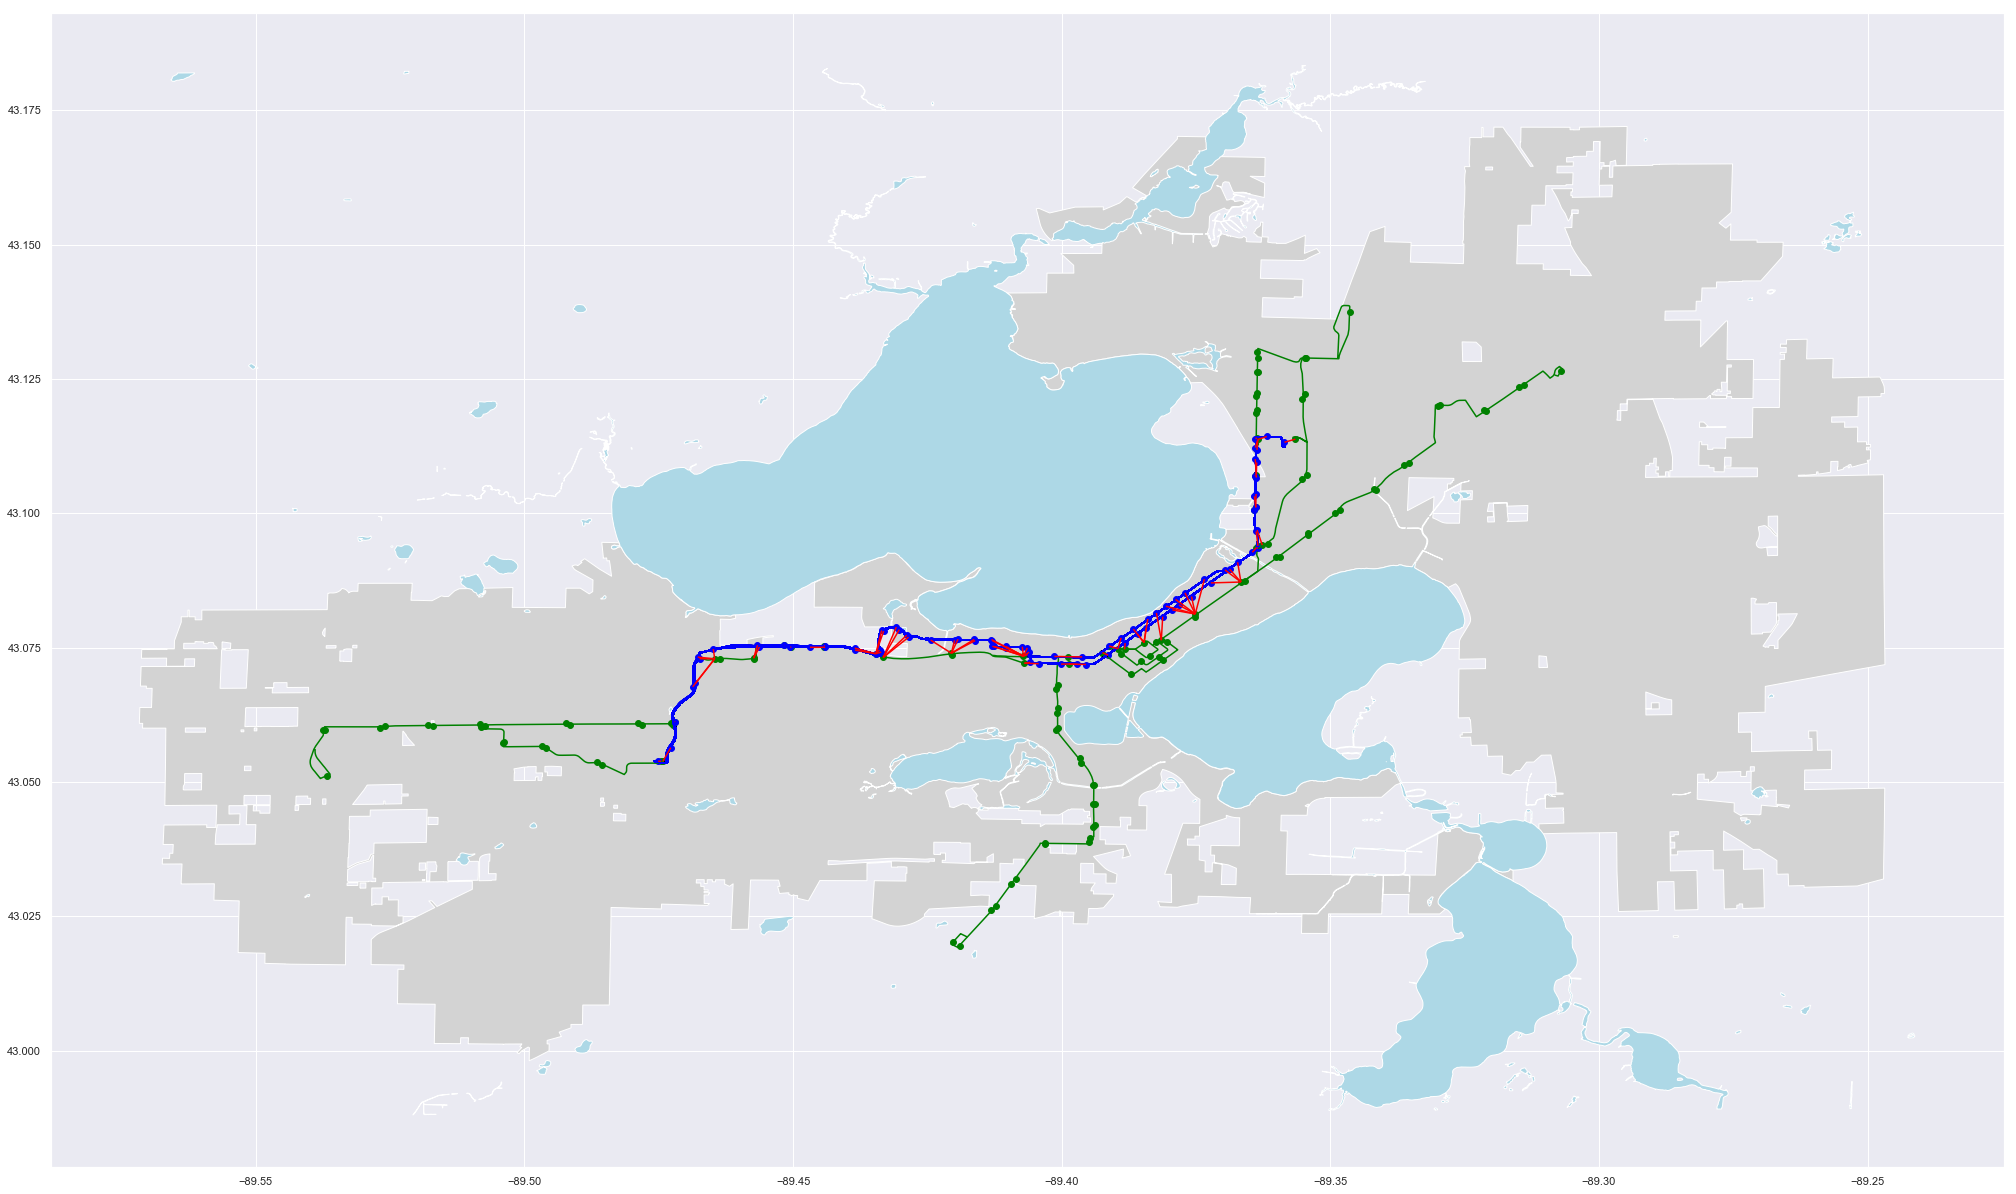

In [13]:
#bus 28
ax = madison.plot(color="lightgray", figsize=(35,35))
lakes.plot(color="lightblue", ax=ax)
brt_coord.plot(color="green", ax=ax, markersize= 35)
brt_coord_line.plot(color="green", ax=ax)

route_number_table = weekday_bus[weekday_bus['Route'] == 28
                                ]
mapping(route_number_table)
route_number_table.distance_to_brt = route_number_table.distance_to_brt.astype(float)
route_number_table['distance_to_brt'].describe()


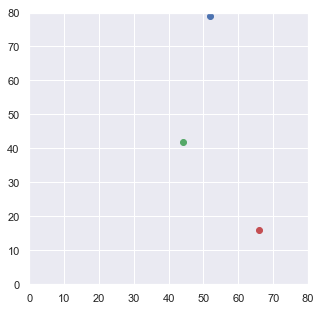

In [19]:
np.random.seed(200)
k = 3
# centroids[i] = [x, y]
centroids = {
    i+1: [np.random.randint(40, 80), np.random.randint(0, 80)]
    for i in range(k)
}
    
fig = plt.figure(figsize=(5, 5))
plt.scatter(weekday_bus['Lat'], weekday_bus['Lon'], color='k')
colmap = {1: 'r', 2: 'g', 3: 'b'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

   OBJECTID  StopID  Route        Lat        Lon  DailyBoard     DotSize  \
0     16341    4100      4  43.038895 -89.394824      189.84  1898447.45   
1     16342    4100      5  43.038895 -89.394824      210.71  2107109.73   
2     16343    4100     13  43.038895 -89.394824       79.50   795000.00   
3     16344    4100     16  43.038895 -89.394824      185.31  1853106.79   
4     16345    4100     18  43.038895 -89.394824      299.38  2993805.57   

                                       geometry brt_index distance_to_brt  \
0  POINT (-89.39481797199609 43.03888706322148)        59     0.000143962   
1  POINT (-89.39481797199609 43.03888706322148)        59     0.000143962   
2  POINT (-89.39481797199609 43.03888706322148)        59     0.000143962   
3  POINT (-89.39481797199609 43.03888706322148)        59     0.000143962   
4  POINT (-89.39481797199609 43.03888706322148)        59     0.000143962   

   distance_from_1  distance_from_2  distance_from_3  closest color  
0       10

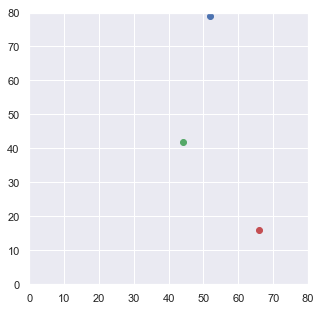

In [22]:
df = weekday_bus

def assignment(df, centroids):
    for i in centroids.keys():
        
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['Lat'] - centroids[i][0]) ** 2
                + (df['Lon'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

df = assignment(df, centroids)
print(df.head())

fig = plt.figure(figsize=(5, 5))
plt.scatter(df['Lat'], df['Lon'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

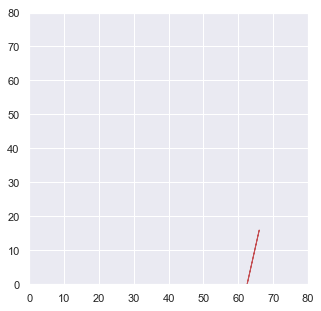

In [23]:
import copy

old_centroids = copy.deepcopy(centroids)

def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['Lat'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['Lon'])
    return k

centroids = update(centroids)
    
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(df['Lat'], df['Lon'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(old_x, old_y, dx, dy, head_width=2, head_length=3, fc=colmap[i], ec=colmap[i])
plt.show()